<a href="https://colab.research.google.com/github/asnoldy02-cell/sds510/blob/main/Module_7_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import os
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime

In [109]:
print("Downloading NVD CVE feed...")

NVD_URL = "https://services.nvd.nist.gov/rest/json/cves/2.0?resultsPerPage=10"

headers = {
    "apiKey": NVD_API_KEY,
    "User-Agent": "University-Research-Student/1.0" # or your application name and version
}

resp = requests.get(NVD_URL, headers=headers)

if resp.status_code != 200:
    print(f"Error fetching NVD data: Status Code {resp.status_code}")
    print(f"Response content: {resp.text}")
    raise ConnectionError(f"Failed to fetch NVD data. Status code: {resp.status_code}")

nvd_json = resp.json()

cve_items = nvd_json.get("vulnerabilities", [])

def extract_cve_fields(item):
    cve = item["cve"]
    cve_id = cve["id"]
    published = cve.get("published", None)

    cvss_score = None
    vendors = []
    products = []

    metrics = cve.get("metrics", {})
    if "cvssMetricV31" in metrics:
        cvss_score = metrics["cvssMetricV31"][0]["cvssData"]["baseScore"]
    elif "cvssMetricV30" in metrics:
        cvss_score = metrics["cvssMetricV30"][0]["cvssData"]["baseScore"]
    elif "cvssMetricV2" in metrics:
        cvss_score = metrics["cvssMetricV2"][0]["cvssData"]["baseScore"]

    for vendor_data in cve.get("configurations", []):
        for node in vendor_data.get("nodes", []):
            for cpe in node.get("cpeMatch", []):
                cpe_str = cpe.get("criteria", "")
                parts = cpe_str.split(":")
                if len(parts) > 4:
                    vendors.append(parts[3])
                    products.append(parts[4])

    return {
        "cve_id": cve_id,
        "published": published,
        "cvss": cvss_score,
        "vendors": ";".join(set(vendors)),
        "products": ";".join(set(products))
    }

nvd_df = pd.DataFrame([extract_cve_fields(i) for i in cve_items])
nvd_df["published"] = pd.to_datetime(nvd_df["published"])

print("Loaded NVD CVE records:", len(nvd_df))

Loaded NVD CVE records: 10


In [112]:
print("Downloading CISA exploited CVE list...")

# Updated CISA URL to the current known location for the KEV catalog
CISA_URL = "https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv"
cisa_df = pd.read_csv(CISA_URL)

cisa_df.rename(columns={"cveID": "cve_id"}, inplace=True)
exploited_ids = set(cisa_df["cve_id"].unique())

print("Loaded CISA exploited CVEs:", len(exploited_ids))

Loaded CISA exploited CVEs: 1464


In [113]:
nvd_df["exploited"] = nvd_df["cve_id"].isin(exploited_ids)

exploited_df = nvd_df[nvd_df["exploited"] == True]

print("Matched exploited CVEs in NVD:", len(exploited_df))



Matched exploited CVEs in NVD: 0


In [114]:
INCIDENT_FILE = "incidents.csv"   # change to your filename

if os.path.exists(INCIDENT_FILE):
    incidents = pd.read_csv(INCIDENT_FILE)
    print("Loaded incident dataset:", len(incidents))

    # Try a join on CVE IDs (if present)
    if "cve_id" in incidents.columns:
        merged = incidents.merge(nvd_df, on="cve_id", how="left")
        print("Merged incident records:", len(merged))
    else:
        merged = None
        print("Incident dataset does not contain cve_id field.")
else:
    incidents = None
    merged = None
    print("No incident dataset found. Skipping join.")


No incident dataset found. Skipping join.


Generating plots...


/tmp/ipython-input-3202731424.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = nvd_df.set_index("published").resample("M")["cve_id"].count()
/tmp/ipython-input-3202731424.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_ex = nvd_df[nvd_df["exploited"]].set_index("published").resample("M")["cve_id"].count()


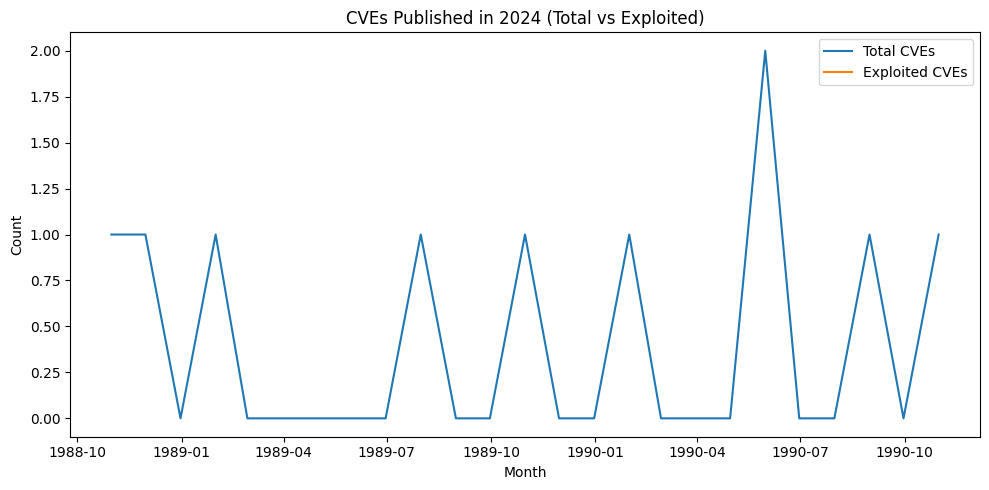


Top Exploited Vendors:
Series([], Name: count, dtype: int64)


In [115]:
print("Generating plots...")

# --- Time series: total vs exploited CVEs ---
ts = nvd_df.set_index("published").resample("M")["cve_id"].count()
ts_ex = nvd_df[nvd_df["exploited"]].set_index("published").resample("M")["cve_id"].count()

plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts.values, label="Total CVEs")
plt.plot(ts_ex.index, ts_ex.values, label="Exploited CVEs")
plt.title("CVEs Published in 2024 (Total vs Exploited)")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("cve_timeseries.png", dpi=300)
plt.show()

# --- Top exploited vendors ---
top_vendors = (
    exploited_df["vendors"]
    .str.split(";")
    .explode()
    .value_counts()
    .head(15)
)

print("\nTop Exploited Vendors:")
print(top_vendors)


In [116]:
nvd_df.to_csv("nvd_2024_clean.csv", index=False)
exploited_df.to_csv("nvd_2024_exploited.csv", index=False)

if merged is not None:
    merged.to_csv("incident_merged_output.csv", index=False)

print("\nPipeline complete. Files saved locally:")
print("- nvd_2024_clean.csv")
print("- nvd_2024_exploited.csv")
if merged is not None:
    print("- incident_merged_output.csv")
print("- cve_timeseries.png")



Pipeline complete. Files saved locally:
- nvd_2024_clean.csv
- nvd_2024_exploited.csv
- cve_timeseries.png
